# Bayesian Multivariate Regression

This notebook introduces multi-variate regression from a Bayesian perspective. Knowledge of basic statistics, inclduing Bayesian techniques is required. If you need a notebook on that, check with C. Miller.

We are going to use PYMC, including the triangle libraries to plot the Bayesian posteriors.

## The libraries

In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm
import triangle
from IPython.display import display, Math, Latex
%matplotlib inline
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
#from __future__ import print_function
import pymc
from pymc import AdaptiveMetropolis 
import random
from IPython.display import Image


Couldn't import dot_parser, loading of dot files will not be possible.


We will be regression the following function:
$\bf{y} = \alpha + \beta \bf{x} + \gamma {\bf z} $

where $\alpha, \beta$, and $\gamma$ are the parameters we are interested in. The independent variables are $\bf{x,z}$ and the dependent variable is $\bf{y}$. In other words, in this example, $\bf{x}$ and $\bf{z}$ do not depend on each other, but $\bf{y}$ depends on some combination of both $\bf{x}$ and $\bf{z}$. 

A future addition to this notebook will be to incorporate covariant dependence between  $\bf{x}$ and $\bf{z}$.

Note that the independent and dependent variables are vectors (e.g., the data). The parameters are scalars.

## Create the  Data

In [68]:
N_obs = 1000
random.seed(9006)
# Set the model coefficients
alpha = 4.0
beta = 0.7
gamma = 0.4
#sigma = 0.01
#sigma_squared = sigma**2

# The data are drawn from Gaussians with means and covariance.

# The independent data can have any values, so I center x and z around 14 and 1. 
mean = [14, 1.0]

# The independent data will correlate weakly or strongly with the dependent variable. For instance, if
# you want the dependent variable to be more strongly correlated with x than z, you would increase the
# covariance with x over the covariance for z. You could also include covariance in the off diagonal terms
# of the covariance matrix. For the tutorial, you should play with these numbers to understand how they are
# affecting the data.
cov = [[0.1,0.0],[0.0,0.5]]
x_true, z_true = np.random.multivariate_normal(mean,cov,N_obs).T

# Now, generate the independent variables from a multivariate normal 
y_true = alpha + beta*(x_true) + gamma*(z_true) # + np.random.normal(0.0,sigma,size=N_obs)

Below, we plot the truth data. Notice that $\bf{y}$ correlates with both $\bf{x}$ and $\bf{z}$, but  $\bf{x}$ and $\bf{z}$ do not correlate with each other. Also note that this is not an unphysical example, where y dependends $\it{exactly}$ on $\bf{x}$ and $\bf{z}$. By drawing from a normal with covariance, we ensure intrinsic scatter is populated all the way through in the relationship.

In [69]:
x_true_label = r"x$_{\rm true}$"    
z_true_label = r"z$_{\rm true}$"
y_true_label = r"y$_{\rm true}$"
fntsz = 20
    
plt.figure(figsize=(18,5))  
plt.subplot(1,3,1)
plt.scatter(x_true, y_true, c=z_true, marker='o', s=20)
cbar = plt.colorbar()
plt.xlabel(x_true_label, fontsize=fntsz)
plt.ylabel(y_true_label, fontsize=fntsz)
cbar.set_label(z_true_label, fontsize=fntsz)
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('The underlying true data')
plt.xlim(12.0,15.5)
    
plt.subplot(1,3,2)
plt.scatter(z_true, y_true, c=x_true, marker='o', s=20)
cbar = plt.colorbar()
plt.xlabel(z_true_label, fontsize=fntsz)
plt.ylabel(y_true_label, fontsize=fntsz)
cbar.set_label(x_true_label, fontsize=fntsz)
plt.title('The underlying true data')
plt.ticklabel_format(useOffset=False, style='plain')

plt.subplot(1,3,3)
plt.scatter(x_true, z_true, c=y_true, marker='o', s=20)
cbar = plt.colorbar()
plt.xlabel(x_true_label, fontsize=fntsz)
plt.ylabel(z_true_label, fontsize=fntsz)
cbar.set_label(y_true_label, fontsize=fntsz)
plt.tight_layout()
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('The underlying true data')
plt.show()

Things will look less rosy once we add in measurement error.

In [70]:

# Set the measurement uncertainties on the independent and dependent variables
sigma_x_obs = 0.5 #Halo masses (dex)
sigma_z_obs = 0.1 #Magnitudes (dex)
sigma_y_obs = 0.15  #Stellar Masses (dex)

#The observed quantities all have measurement error.
x_obs = x_true + np.random.normal(0.0, sigma_x_obs, size=N_obs)
z_obs = z_true + np.random.normal(0.0, sigma_z_obs, size=N_obs)
y_obs = y_true + np.random.normal(0.0, sigma_y_obs, size=N_obs)

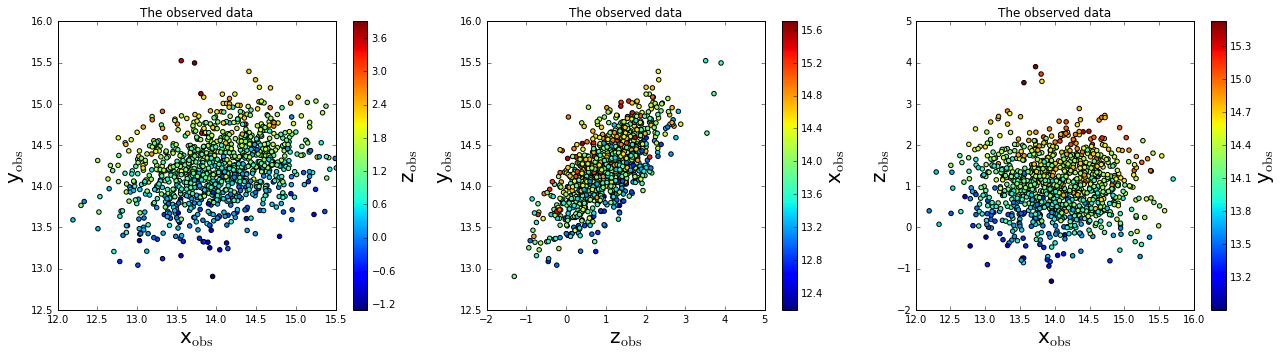

In [71]:
x_obs_label = r"x$_{\rm obs}$"    
z_obs_label = r"z$_{\rm obs}$"
y_obs_label = r"y$_{\rm obs}$"
fntsz = 20
    
plt.figure(figsize=(18,5))  
plt.subplot(1,3,1)
plt.scatter(x_obs, y_obs, c=z_obs, marker='o', s=20)
cbar = plt.colorbar()
plt.xlabel(x_obs_label, fontsize=fntsz)
plt.ylabel(y_obs_label, fontsize=fntsz)
cbar.set_label(z_obs_label, fontsize=fntsz)
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('The observed data')
plt.xlim(12.0,15.5)
    
plt.subplot(1,3,2)
plt.scatter(z_obs, y_obs, c=x_obs, marker='o', s=20)
cbar = plt.colorbar()
plt.xlabel(z_obs_label, fontsize=fntsz)
plt.ylabel(y_obs_label, fontsize=fntsz)
cbar.set_label(x_obs_label, fontsize=fntsz)
plt.title('The observed data')
plt.ticklabel_format(useOffset=False, style='plain')

plt.subplot(1,3,3)
plt.scatter(x_obs, z_obs, c=y_obs, marker='o', s=20)
cbar = plt.colorbar()
plt.xlabel(x_obs_label, fontsize=fntsz)
plt.ylabel(z_obs_label, fontsize=fntsz)
cbar.set_label(y_obs_label, fontsize=fntsz)
plt.tight_layout()
plt.title('The observed data')
plt.ticklabel_format(useOffset=False, style='plain')

plt.show()

Note above that the "measurement error" is larger for $\bf{x}$ than for $\bf{z}$, which blurs out the correlation with $\bf{y}$ (worse for $\bf{x}$).

## Linear regression against one variable

Now, let us treat these data as if we know nothing about it. For fun, let's say that you didn't know about the third variable and thought that there should be a linear relationship between $\bf{x}$ and $\bf{y}$:

In [78]:
beta0, alpha0 = np.polyfit(x_obs, y_obs, 1) 
var0 = ((alpha0 + beta0*x_obs - y_obs)**2.).sum()/len(x_obs)
tau0 = 1./var0 
print 'intercept: ', alpha0
print 'slope: ', beta0
print 'scatter: ', np.sqrt(var0)

intercept:  11.4549912088
slope:  0.196943250149
scatter:  0.366051763163


We see that that the intercept and slope are no where near what we expect: 4 and 0.7. This is for TWO reasons: (1) there is a third parameter playing an important role and (2) there is meaaurement error in both the dependent and independent variables. This scatter is known to "flatten" linear relationships. 

If you'd like to know more about this, check out thie notebook:
git clone https://chrism71@bitbucket.org/chrism71/line-fitting.git

## Bayesian regression

In [80]:
tau_x = 1./sigma_x_obs**2. 
tau_y = 1./sigma_y_obs**2.
tau_z = 1./sigma_z_obs**2.

#define prior on the intercept
alpha = pymc.Uniform('alpha', 0,10) 

#define the prior on the slope beta. This may look weird to you. See Chapter 8.8 in Statistics, Data Mining, and Machine Learning in Astronomy
@pymc.stochastic(observed=False)
def beta(value=0):
    return -1.5 * np.log(1 + value**2)

#define a prior on gamma
gamma = pymc.Uniform('gamma', 0,10) 

#Define individual priors on the measurement errors for y. This is here because in many cases you will have heteroscedastic errors.
#In this demo, all y errors are the same, so this isn't really doing anything.
sigma_yi = pymc.Uniform('sigma_yi',0,100, value=sigma_y_obs)
@pymc.deterministic 
def tau_yi(sigma_yi=sigma_yi): 
            return 1./sigma_yi**2.     

#This defines how the MCMC will draw the x values. We are using the data (mean and variance) to do this. This is an important component
#and one that is neglected in common chi2 likelihood analyses (e.g., grid-based approaches). If you were to choose a uniform grid of x-values,
#you are placing a strong (but hidden) prior on your statistical analysis. 
mu_xi = pymc.Normal('mu_xi', 0., 1.e-6, value=x_obs.mean()) 
tau_xi = pymc.Gamma('tau_xi', 0.001, 0.001, value=1./x_obs.var()) 
xi = pymc.Normal('xi', mu_xi, tau_xi, value=x_obs) 

#ditto for z
mu_zi = pymc.Normal('mu_zi', 0., 1.e-6, value=z_obs.mean()) 
tau_zi = pymc.Gamma('tau_zi', 0.001, 0.001, value=1./z_obs.var()) 
zi = pymc.Normal('zi', mu_zi, tau_zi, value=z_obs) 
#zi = pymc.Uniform('zi',lower=-10, upper=10, value=z_obs)

#the modeled y (here called mu) is then calculated from the MCMC sampling of the parameters:
@pymc.deterministic 
def mu(xi=xi,zi=zi, alpha=alpha, beta=beta, gamma=gamma): 
    fit = alpha + beta*(xi) + gamma*(zi)
    return fit

#In this multivariate analysis, you are jointly regressing against x,y,z. In other words, the x's that you are feeding into the analysis
#need to look like the observed x's (within error). Ditto for y's and z's. Observed=True means regress.
x = pymc.Normal('x', xi, tau_x, value=x_obs, observed=True) 
y = pymc.Normal('y', mu, tau_yi, value=y_obs, observed=True)
z = pymc.Normal('z', zi, tau_z, value=z_obs, observed=True)

### Re-package the model for ease and plotting

We also plot the model network. Reading this diagram can be very helpful to understanding the depth
of your model, where is superfluous, what is missing, etc.

Anything with a circle is a part of the model (i.e., it floats around in the MCMC).

Anything grey is compared to real data.

Upside down triangles clarify when something is deterministic (i.e., not random).

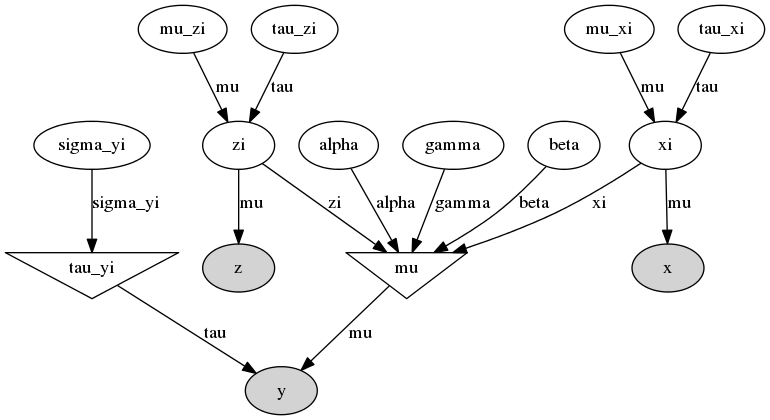

In [87]:
theta = [alpha, beta, gamma, mu, y, mu_xi, tau_xi, xi, x, mu_zi, tau_zi, zi,z, tau_yi]
model = pymc.Model(theta)
import pymc.graph
graph = pymc.graph.graph(model)
graph.write_png('/u/home/christoq/test.png')
Image(filename='/u/home/christoq/test.png')

A quick summary of the model:

zi's are generated and compared to observed z's. zi's are created from priors that are normal with mean and inverse variance, which in this case stems from the data (this last part is in the code).

xi's are generated and compared to observed x's. xi's are created from priors that are normal with mean and inverse variance, which in this case stems from the data (this last part is in the code).

xi's and zi's, combined with alpha, beta, gamma (each with their own priors) to create mu.

mu is compared to y given a normal likelihood. This requires the mean (mu) and the inverse variance (or error) on y.


### Run the chains

In [95]:

#theta = [alpha, beta, tau_xi,tau_yi,x,y,xi]
M = pymc.MCMC(theta) 
# Force the use of AdaptiveMetropolis step method . This is very helpful in making efficiently sampling 
#for correlated data like we have here.
M.use_step_method(pymc.AdaptiveMetropolis, [alpha,beta,gamma],scales={alpha:0.01, beta:0.01,gamma:0.01})
#Run the sampler using 5 million steps. Burn in the first million (and then start to keep notes). Average
#together the results of each 100 steps to conserve memory).
M.sample(5000000, 1000000,100) 

 [                  0%                  ] 1090 of 5000000 complete in 1.5 sec

/u/home/christoq/anaconda/lib/python2.7/site-packages/pymc/StepMethods.py:1272: UserWarning: 
Covariance was not positive definite and proposal_sd cannot be computed by 
Cholesky decomposition. The next jumps will be based on the last 
valid covariance matrix. This situation may have arisen because no 
jumps were accepted during the last `interval`. One solution is to 
increase the interval, or specify an initial covariance matrix with 
a smaller variance. For this simulation, each time a similar error 
occurs, proposal_sd will be reduced by a factor .9 to reduce the 
jumps and increase the likelihood of accepted jumps.
  warnings.warn(adjustmentwarning)


 [-----------------100%-----------------] 5000000 of 5000000 complete in 5454.5 sec

### Plot and print the results.

Recall that the intercept was defined as 4, the slope beta as 0.7 and the third parameter gamma as 0.4.

The following plots show the full "trace", which is where the MCMC spends its time. These traces are plotted as a function of the step (actually, the average over 100 steps)

Notice that the recovered medians of the $\alpha$, $\beta$, and $\gamma$ are very good. The errors (wheich you can measure in various ways given the traces) are also pretty small (tha largest being for alpha)

Notice that the autocorrelations are often high. This is not necessarily bad. The samples are correlated and
the sampler is probably at fault. But this is often just reality, and the fact that the slope and intercept
are highly correlated is built into this type of problem.

Plotting mu_xi
Plotting tau_xi
Plotting beta
Plotting alpha
Plotting tau_yi
Plotting tau_zi
Plotting gamma
Plotting mu_zi
3.90136148556 0.707560028037 0.393945332588


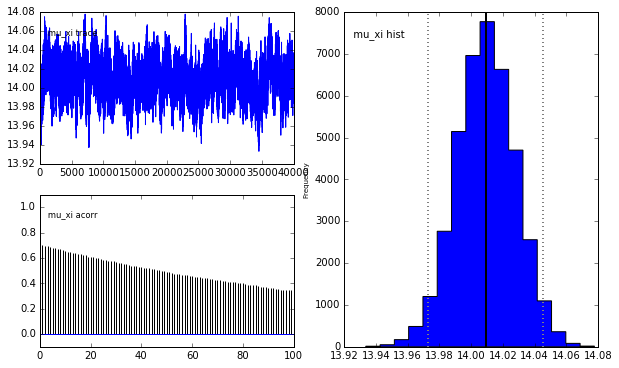

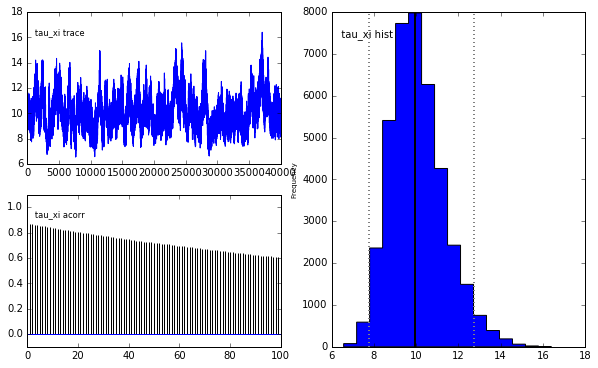

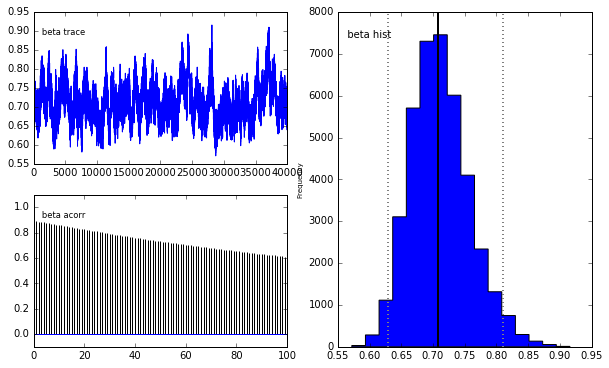

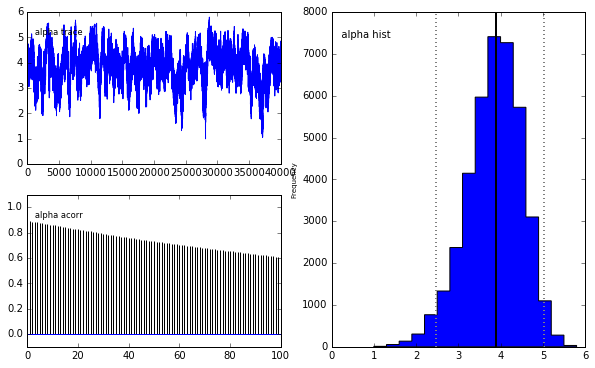

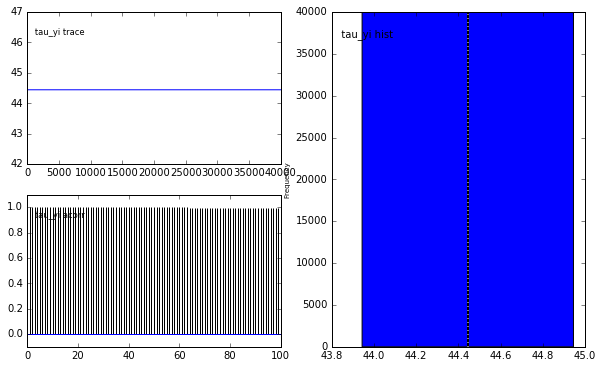

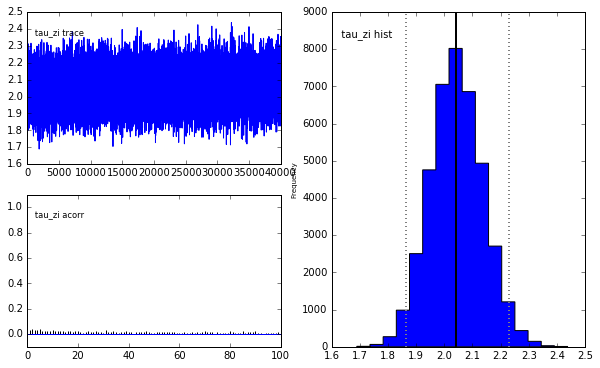

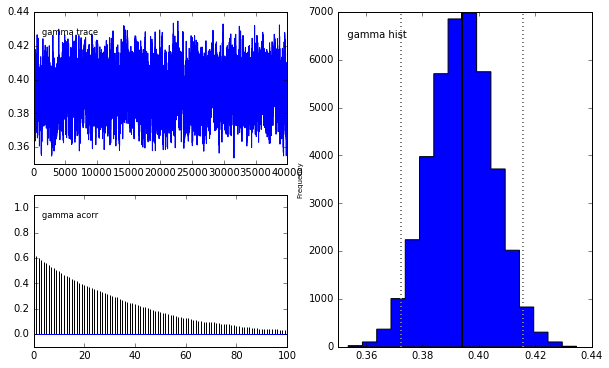

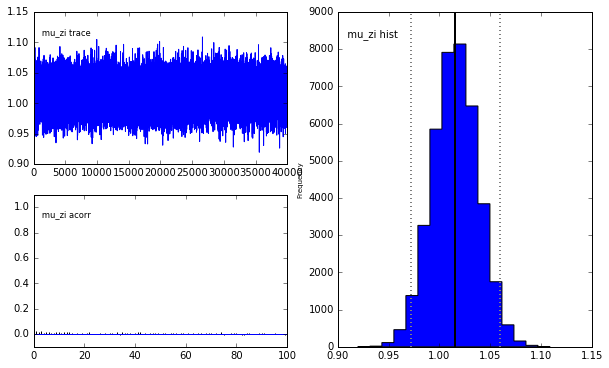

In [96]:
pymc_trace = [M.trace('alpha')[:],
              M.trace('beta')[:],
              M.trace('gamma')[:]]

pymc.Matplot.plot(M)

m_alpha = np.median(pymc_trace[0])
m_beta = np.median(pymc_trace[1])
m_gamma = np.median(pymc_trace[2])

print m_alpha, m_beta, m_gamma#, sigma_xi, sigma_yi
#y_fit5 = m_alpha + m_beta*xdata

#plot_MCMC_results(x_obs, y_obs,z_obs, pymc_trace)
#print alpha, m_alpha
#print beta, m_beta
#print gamma, m_gamma